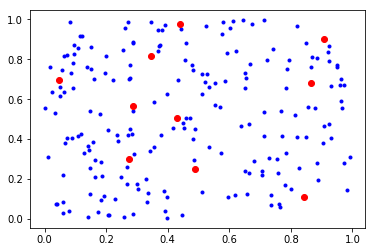

In [1]:
import numpy as np
import matplotlib.pyplot as plt

num_people = 200
num_restaurants = 10
t_initial_period = 100
t_final = 365
p_going_restaurant = 0.7

coord_people = np.random.rand(num_people,2)
coord_restaurants = np.random.rand(num_restaurants,2)

plt.plot(coord_people[:,0],coord_people[:,1],'b.')
plt.plot(coord_restaurants[:,0],coord_restaurants[:,1],'ro')
plt.show()

In [2]:
# Distance and probability calcualtion for each individual over 
import scipy as sp
from scipy.spatial.distance import cdist
dist_people_restaurants = cdist(coord_restaurants,coord_people)
dist_normalization = dist_people_restaurants.sum(axis=0)
p_people_restaurant_weekdays = np.divide(dist_people_restaurants,dist_normalization)*p_going_restaurant
p_people_restaurant_weekdays = np.concatenate((p_people_restaurant_weekdays,np.full((1,num_people),1-p_going_restaurant)))
p_people_restaurant_weekends = np.divide(dist_people_restaurants,dist_normalization)*p_going_restaurant/2
p_people_restaurant_weekends = np.concatenate((p_people_restaurant_weekends,np.full((1,num_people),1-p_going_restaurant/2)))

In [3]:
# rows are people, columns are days
idx_restaurans = np.arange(num_restaurants+1)
visit_people = np.zeros((num_people,t_initial_period))
i_days = np.arange(t_initial_period)
days_weekdays = i_days%7<5
days_weekends = np.invert(days_weekdays)
for i in range(num_people):
    visit_people[i,days_weekdays] = np.random.choice(idx_restaurans,np.sum(days_weekdays),p=p_people_restaurant_weekdays[:,i])
    visit_people[i,days_weekends] = np.random.choice(idx_restaurans,np.sum(days_weekends),p=p_people_restaurant_weekends[:,i])


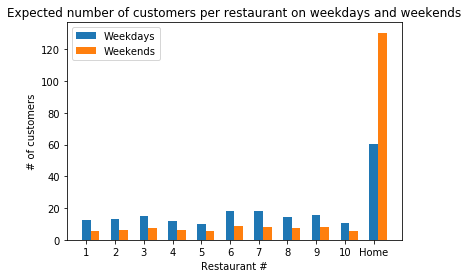

In [16]:
H_weekdays, _ = np.histogram(visit_people[:,days_weekdays],bins=num_restaurants+1)
H_weekends, _ = np.histogram(visit_people[:,days_weekends],bins=num_restaurants+1)
plt.bar(np.arange(num_restaurants+1),H_weekdays/np.sum(days_weekdays),0.3)
plt.bar(np.arange(num_restaurants+1)+0.3,H_weekends/np.sum(days_weekends),0.3)
plt.title('Expected number of customers per restaurant on weekdays and weekends')
plt.xlabel('Restaurant #')
plt.ylabel('# of customers')
plt.legend(['Weekdays','Weekends'])
plt.xticks(np.arange(num_restaurants+1),[str(x) for x in range(1,num_restaurants+1)]+['Home'])
plt.show()

In [18]:
import pandas as pd
pd.DataFrame(visit_people)